In [1]:
%cd ..
%load_ext autoreload

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code


In [49]:
import enum
import seaborn as sns
from data_handling.Data_Processor import DataProcessor
import constants
from statistics_methods.Statistics import StatisticsWrapper
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

In [37]:
chosen_rois_dict = constants.ROI_CORTEX
params_to_work_with = constants.ALL_PARAMS

In [38]:
def load_data(data_path, slopes=None, outliers=[]):
    subjects_raw_data = DataProcessor(data_path, chosen_rois_dict, chosen_rois_dict).get_data_proccessed()
    analyzed_data = StatisticsWrapper.calc_median_per_subject_per_parameter_per_ROI(subjects_raw_data, params_to_work_with)
    chosen_data = StatisticsWrapper.chose_relevant_data(analyzed_data, chosen_rois_dict, params_to_work_with, params_to_work_with)

    chosen_data = chosen_data[~chosen_data.subjects.isin(outliers)]

    group_a_name, group_b_name, col_divider, threshold = constants.YOUNG, constants.OLD, 'Age', constants.AGE_THRESHOLD
    young_subjects, old_subjects = StatisticsWrapper.seperate_data_to_two_groups(chosen_data, col_divider, threshold)

    return chosen_data, young_subjects, old_subjects

In [5]:
outliers = ['H047_DC', 'H036_EV', 'H054_AE', 'H046_NB']
# outliers = []
chosen_data_raw, young_subjects_raw, old_subjects_raw = load_data(constants.PATH_TO_CORTEX_all_params_raw, outliers=outliers)
chosen_data_z_score, young_subjects_z_score, old_subjects_z_score = load_data(constants.PATH_TO_CORTEX_all_params_z_score, outliers=outliers)

In [55]:
data = chosen_data_raw.copy()
young_mask = young_subjects_raw.index
old_mask = old_subjects_raw.index

# Assign labels directly to data_reduced_tsne DataFrame
data.loc[young_mask, 'label'] = 0
data.loc[old_mask, 'label'] = 1

data = data.sample(frac=1)

x, y = data[params_to_work_with], data['label']

In [57]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model = xgb.XGBClassifier()

In [58]:
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [59]:
#Making predictions on the test set
predictions = model.predict(x_test)

#Calculating accuracy
accuracy = accuracy_score(y_test, predictions)

print("Accuracy:", accuracy)
print("\nClassification Report:")
predictions
print(classification_report(y_test, predictions, target_names=['young', 'old']))

Accuracy: 0.8588588588588588

Classification Report:
              precision    recall  f1-score   support

       young       0.85      0.87      0.86       166
         old       0.87      0.85      0.86       167

    accuracy                           0.86       333
   macro avg       0.86      0.86      0.86       333
weighted avg       0.86      0.86      0.86       333



<AxesSubplot: title={'center': 'Feature importance'}, xlabel='gain', ylabel='Features'>

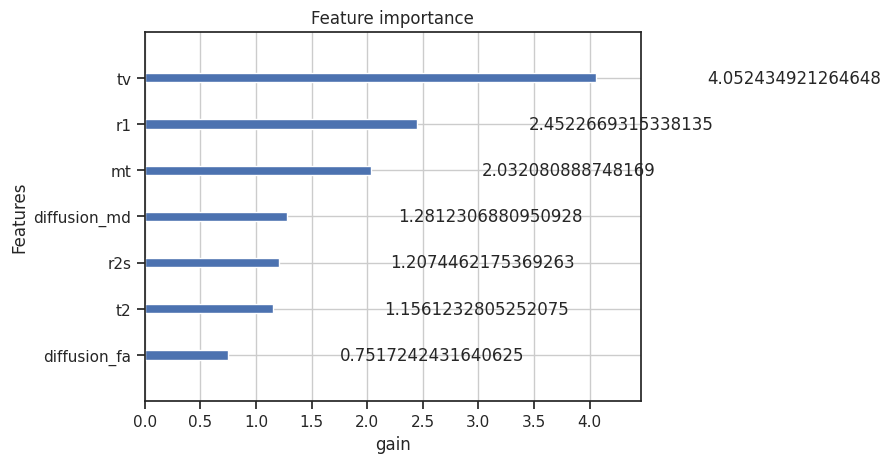

In [60]:
xgb.plot_importance(model, importance_type='gain', xlabel='gain')